## **Task 2.1: Streaming Data Visualisation**

<IPython.core.display.Javascript object>


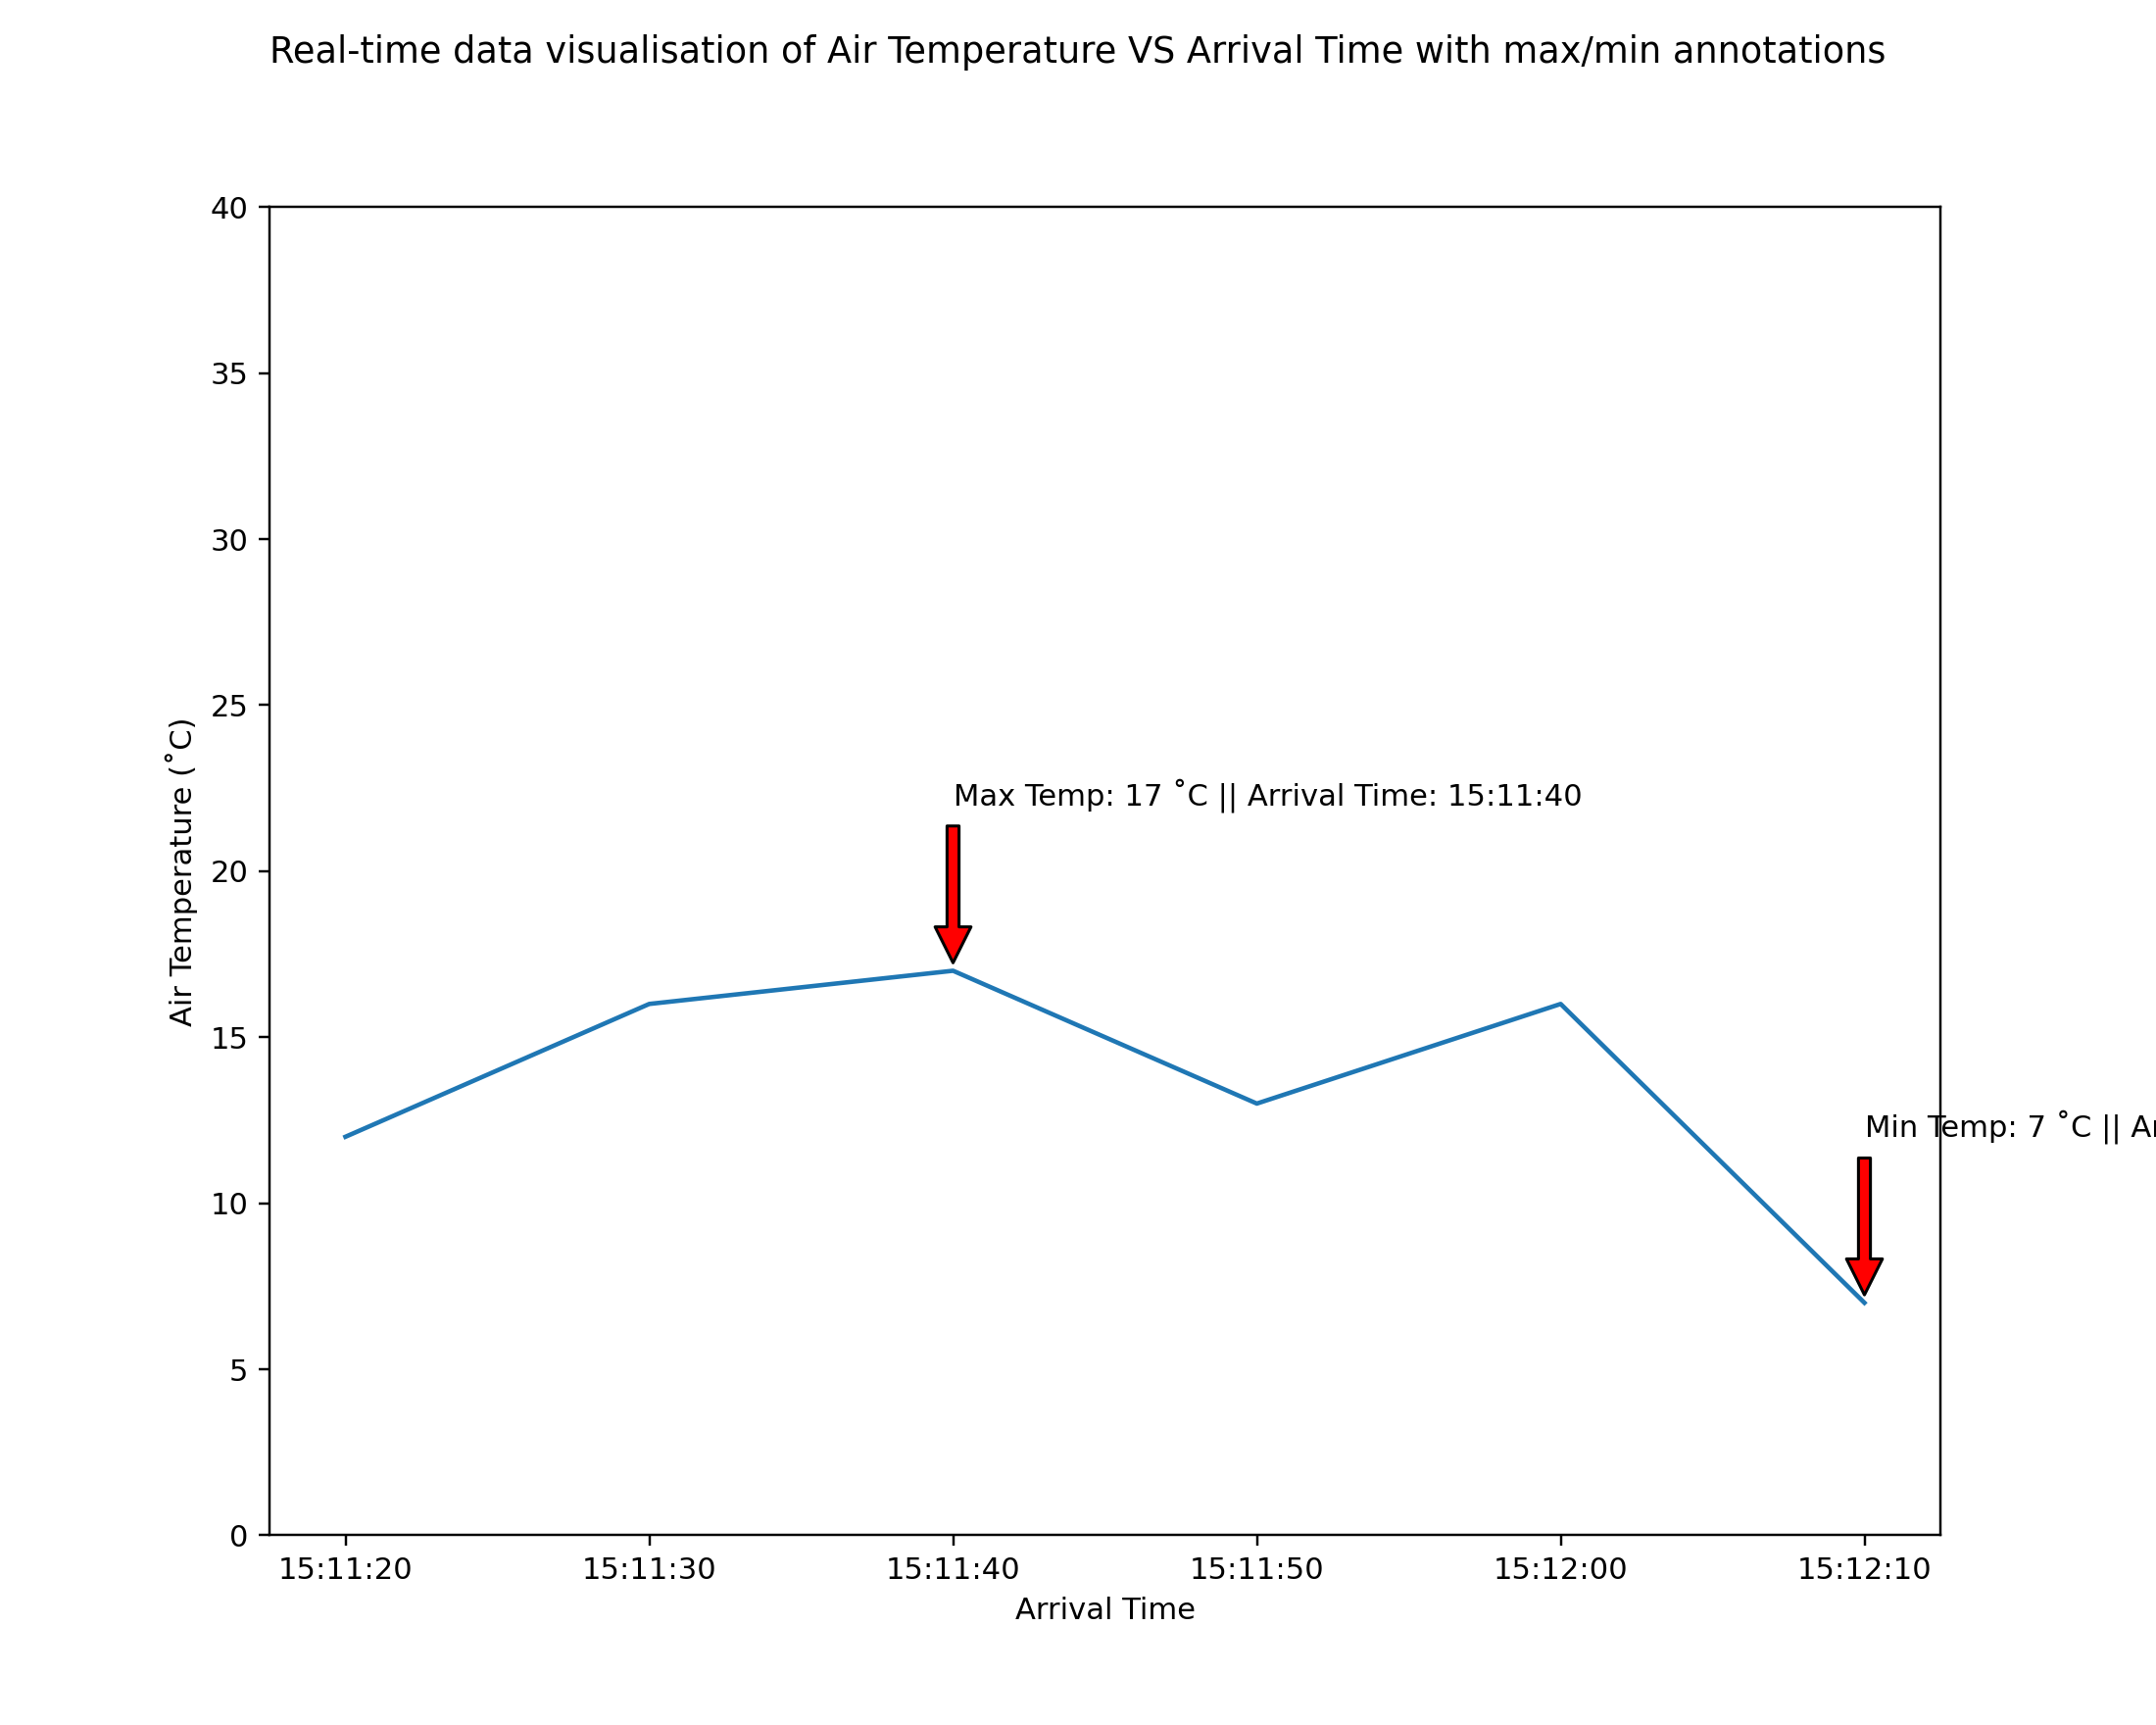

KeyboardInterrupt: 

In [24]:
# import statements
from kafka3 import KafkaConsumer
from datetime import datetime
import json 
import matplotlib.pyplot as plt

#widget for display of graphs in Jupyter Notebook
%matplotlib notebook

ip_address = "10.192.68.151" 
topic_name = 'climate_hotspot' 


def show_max(x_points, y_points, plot_axes = None):

    #get max temperature value's x,y coordinates
    max_temp = max(y_points)
    arrival_pos = y_points.index(max_temp)
    max_temp_arrival = x_points[arrival_pos]

    #display string
    annotate_text = f"Max Temp: {max_temp} ˚C || Arrival Time: {max_temp_arrival}"

    if not plot_axes:
        plot_axes=plt.gca()

    plot_axes.annotate(annotate_text, 
                       xy=(max_temp_arrival, max_temp), 
                       xytext=(max_temp_arrival, max_temp+5), 
                       arrowprops=dict(facecolor='red', shrink=0.05))
    
    
def show_min(x_points, y_points, plot_axes = None):

    #get min temperature value's x,y coordinates
    min_temp = min(y_points)
    arrival_pos = y_points.index(min_temp)
    min_temp_arrival = x_points[arrival_pos]

    #display string
    annotate_text = f"Min Temp: {min_temp} ˚C || Arrival Time: {min_temp_arrival}"

    if not plot_axes:
        plot_axes=plt.gca()

    plot_axes.annotate(annotate_text, 
                       xy=(min_temp_arrival, min_temp), 
                       xytext=(min_temp_arrival, min_temp+5), 
                       arrowprops=dict(facecolor='red', shrink=0.05))


def create_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic_name,
                                   bootstrap_servers=[f'{ip_address}:9092'],
                                   value_deserializer=lambda x: json.loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as exception:
        print('Error occured while connecting to Kafka')
        print(str(exception))
    finally:
        return _consumer


def setup_plots():
    try:

        #create 10x8 plot 
        fig_width = 10
        fig_height = 8
        plot_figure = plt.figure(figsize=(fig_width,fig_height)) 
        plot_axes = plot_figure.add_subplot(111)  #create figure with 1 plot at 1st index

        #set plot labels, limits, ticks
        plot_axes.set_xlabel('Arrival Time')
        plot_axes.set_ylabel('Air Temperature (˚C)')
        plot_figure.suptitle('Real-time data visualisation of Air Temperature VS Arrival Time with max/min annotations')
        plot_axes.set_ylim(0, 40) 
        plot_axes.set_yticks([0,5,10,15,20,25,30,35,40])

        #display and draw the plot
        plot_figure.show() 
        plot_figure.canvas.draw()
        return plot_figure, plot_axes
    
    except Exception as exception:
        print(str(exception))
    

def plot_incoming_data(kafka_consumer, graph_figure, graph_axes):
    try:
        #container for values of both axes
        x_axis_points = []
        y_axis_points = []

        for message in kafka_consumer:
            data = message.value
            arrival_time = datetime.now().strftime("%X")
            x_axis_points.append(arrival_time) 
            y_axis_points.append(data["air_temperature_celcius"])


            #start plotting only after 5 climate reports come in
            if len(y_axis_points) > 5:
                graph_axes.clear()
                graph_axes.plot(x_axis_points, y_axis_points)

                #set plot labels, limits, ticks
                graph_axes.set_xlabel('Arrival Time')
                graph_axes.set_ylabel('Air Temperature (˚C)')
                graph_figure.suptitle('Real-time data visualisation of Air Temperature VS Arrival Time with max/min annotations')
                graph_axes.set_ylim(0, 40) 
                graph_axes.set_yticks([0,5,10,15,20,25,30,35,40])

                #annotate min/max
                show_max(x_axis_points, y_axis_points, graph_axes)
                show_min(x_axis_points, y_axis_points, graph_axes)
            
                graph_figure.canvas.draw()

                #remove old data to get min/max from new set
                x_axis_points.pop(0) 
                y_axis_points.pop(0)

        plt.close('all')

    except Exception as exception:
        print(str(exception))
    
if __name__ == '__main__':
    
    kafka_consumer = create_kafka_consumer()
    graph_figure, graph_axes= setup_plots()
    plot_incoming_data(kafka_consumer, graph_figure, graph_axes)
    
    

## **Task 2.2: Static Data Visualisation**

**Connect to mongodb**

In [26]:
from pymongo import MongoClient

ip_address = "10.192.68.151" 
mongo_client = MongoClient(ip_address, 27017) 
db = mongo_client["fit3182_assignment_db"] 
streaming_climate_col = db.climates_streaming

##### **a) Bar Chart for visualising total number of fire records in each hour**

<IPython.core.display.Javascript object>


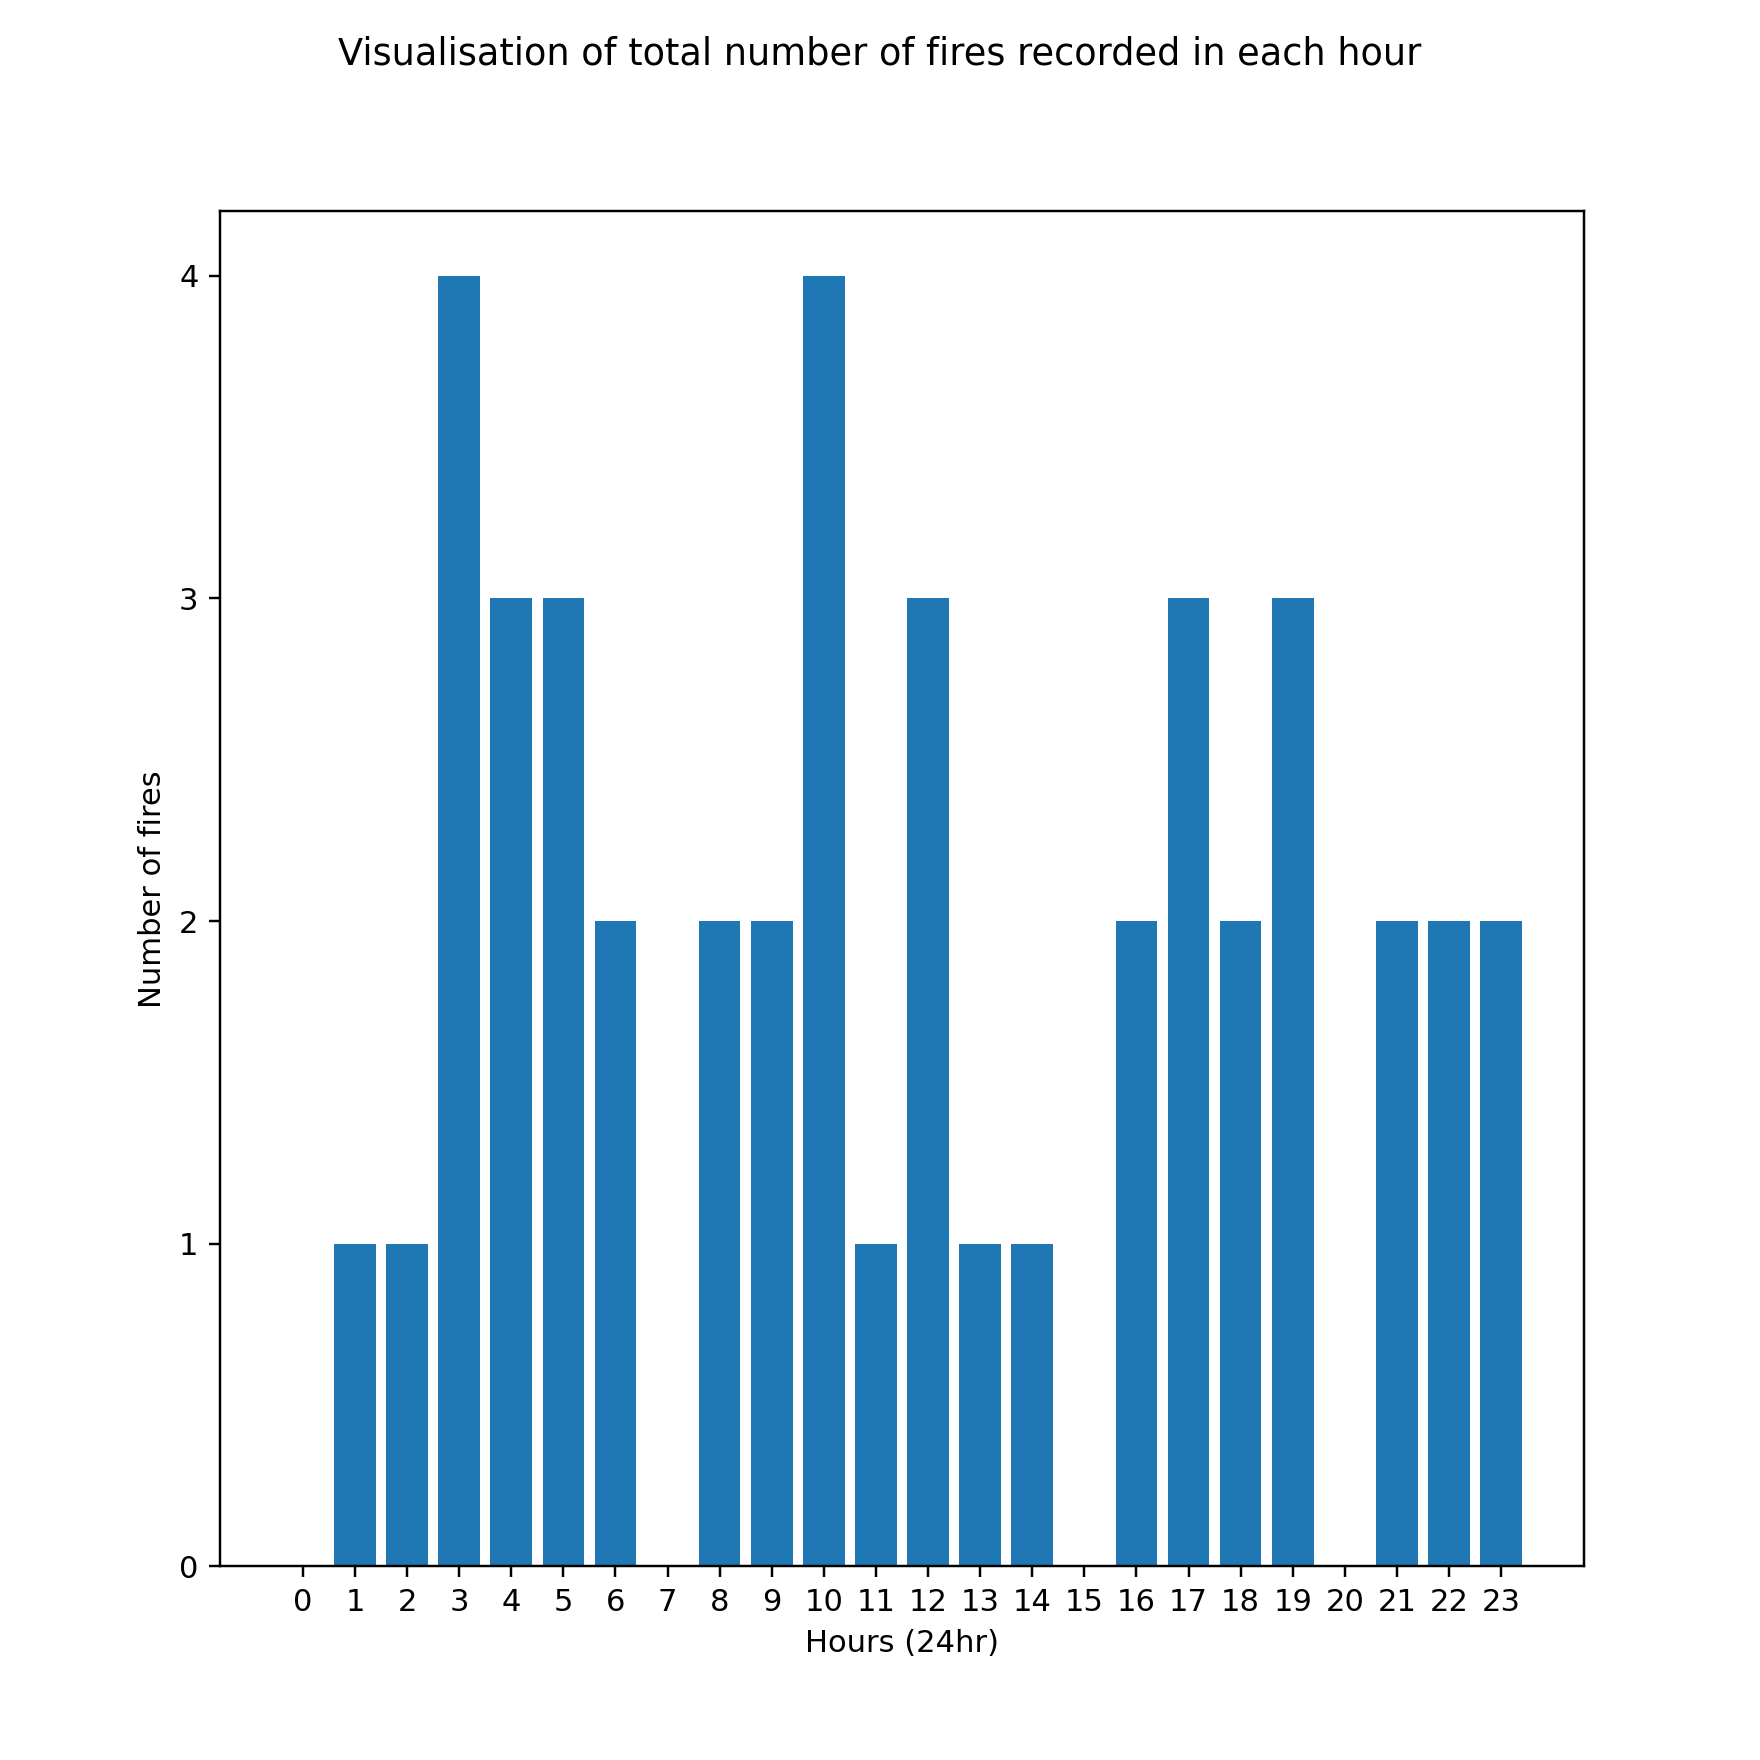

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime

#widget for display of graphs in Jupyter Notebook
%matplotlib notebook


#get the created times of all the hotspots
pipeline_stages = [{"$unwind": "$hotspots"},
                   {"$project": {"_id": 0, 
                                 "time": "$hotspots.created_time"}}]

hotspot_times = streaming_climate_col.aggregate(pipeline_stages)

#list of 24 elements - each representing the number of fires for the particular hour
hourly_fire_count = [0] * 24

#count the number of fires in each hour
for doc in hotspot_times:
    hotspot_hour = doc["time"].split(":")[0]  #get the hour element from HH:MM:SS
    hotspot_hour = int(hotspot_hour)
    hourly_fire_count[hotspot_hour] += 1
    

#container for values of both axes
x_axis_points = []
y_axis_points = hourly_fire_count

# Add each hour count & hour the relative x & y axis for easy plotting.
for hour in range(len(hourly_fire_count)):
    x_axis_points.append(hour)


#create 8x8 plot 
fig_width = 8
fig_height = 8

#create plot for bar chart
plot_figure = plt.figure(figsize=(fig_width,fig_height)) 
plot_axes = plot_figure.add_subplot(111)  #create figure with 1 plot at 1st index

#set plot labels, ticks, limits
plot_axes.set_xlabel('Hours (24hr)')
plot_axes.set_ylabel('Number of fires')
plot_figure.suptitle('Visualisation of total number of fires recorded in each hour')
plot_axes.bar(x_axis_points, y_axis_points)
plot_axes.set_xticks(x_axis_points)
plot_axes.yaxis.set_major_locator(MaxNLocator(integer=True))  #use whole number ticks for y-axis

#display and draw the plot
plot_figure.show()
plot_figure.canvas.draw()

##### **b) Visualising fire locations through a map**

In [ ]:
!pip install folium

In [28]:
import folium

#get the required attributes from the collection
pipeline_stages = [{"$unwind": "$hotspots"},
                   {"$project": {"_id": 0, 
                                 "cause_of_fire": 1,
                                 "air_temperature_celcius": 1,
                                 "relative_humidity": 1,
                                 "surface_temperature_celcius": "$hotspots.surface_temperature_celcius",
                                 "latitude": "$hotspots.latitude",
                                 "longitude": "$hotspots.longitude",
                                 "confidence": "$hotspots.confidence"}}]

map_data = streaming_climate_col.aggregate(pipeline_stages)

#using coordinates of 1st result as center point
for doc in map_data:
    center_lat = doc["latitude"]
    center_long = doc["longitude"]
    break

visual_map = folium.Map(location=[center_lat, center_long], zoom_start=7)  #create map

#set markers for every fire location
for doc in map_data:

    #get coordinates 
    latitude = doc["latitude"]
    longitude = doc["longitude"]
    loc_coordinates = (latitude, longitude)

    #set marker color based on cause of fire
    if doc["cause_of_fire"] == "natural":
        marker_colour = "blue"
    else:
        marker_colour = "red"

    #using html to display details to be shown on popup
    popup_text = f"""
                    <ul>
                        <li>Air Temp: {doc['air_temperature_celcius']} ˚C</li>
                        <li>Surface Temp: {doc['surface_temperature_celcius']} ˚C</li>
                        <li>Relative Humidity: {doc['relative_humidity']}</li>
                        <li>Confidence: {doc['confidence']}</li>
                    </ul>
                 """
    
    marker_popup = folium.Popup(popup_text, max_width=500)

    #add marker to map
    folium.Marker(location=loc_coordinates, 
                  tooltip="Click for detailed info",
                  popup=marker_popup,
                  icon=folium.Icon(color=marker_colour)
                 ).add_to(visual_map)

visual_map  #show map